## Preprocessing

In [8]:
with open("task/train.txt") as file:
    data = file.read()
    train_ids=data.split()
with open("task/valid.txt") as file:
    data = file.read()
    test_ids=data.split()

In [3]:
from PIL import Image

def get_image(img_id):
    image = Image.open(f'images/{img_id}.jpg')
    return image

In [4]:
from xml.dom import minidom
def get_svg_polygons(img_id):
    #source: https://stackoverflow.com/a/15857847
    doc = minidom.parse(f'ground-truth/locations/{img_id}.svg')
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    doc.unlink()
    polygons=[]
    for path_string in path_strings:
        splitted_path_string=path_string.split()
        temp_coor=[]
        polygons.append([])
        for i in range(len(splitted_path_string)):
            if i%3==0 and i!=0:
                polygons[-1].append(tuple(temp_coor))
                temp_coor=[]
            elif i!=0:
                temp_coor.append(float(splitted_path_string[i]))
        
    return polygons

In [5]:
#source: https://stackoverflow.com/a/59208291
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image<255)
    image = Image.fromarray(image, "RGB")
    return image.crop((np.min(x_nonzero), np.min(y_nonzero), np.max(x_nonzero), np.max(y_nonzero)))

In [6]:
import numpy as np
from PIL import ImageDraw
from IPython.display import display
import cv2

def get_binarized_words(img_id):
    polygons=get_svg_polygons(img_id)

    im=get_image(img_id).convert("RGB")
    imArray = np.asarray(im)
    
    binarized_words=[]

    for polygon in polygons:
        #source: https://stackoverflow.com/a/22650239

        maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
        ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
        mask = np.array(maskIm)
        newImArray = np.empty(imArray.shape,dtype='uint8')

        newImArray[:,:,:3] = imArray[:,:,:3]

        newImArray[:,:,0] = np.invert(newImArray[:,:,0])
        newImArray[:,:,1] = np.invert(newImArray[:,:,1])
        newImArray[:,:,2] = np.invert(newImArray[:,:,2])

        newImArray[:,:,0] = newImArray[:,:,0] * mask
        newImArray[:,:,1] = newImArray[:,:,1] * mask
        newImArray[:,:,2] = newImArray[:,:,2] * mask

        newImArray[:,:,0] = np.invert(newImArray[:,:,0])
        newImArray[:,:,1] = np.invert(newImArray[:,:,1])
        newImArray[:,:,2] = np.invert(newImArray[:,:,2])

        newIm=crop(newImArray)

        img = np.array(newIm)
        img = img[:, :, ::-1].copy() 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        blur = cv2.GaussianBlur(img,(5,5),0)

        _,bin_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        binarized_words.append(Image.fromarray(bin_img))

    return binarized_words



In [9]:
import random
train_id=random.choice(train_ids)

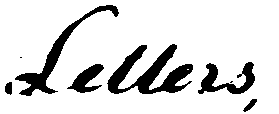

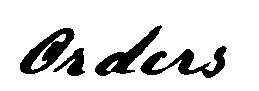

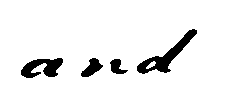

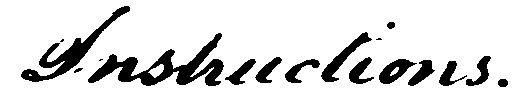

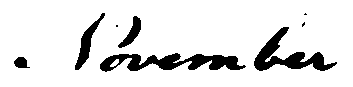

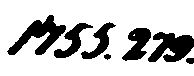

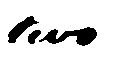

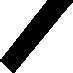

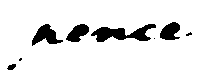

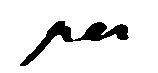

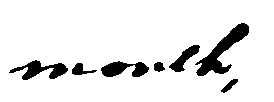

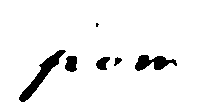

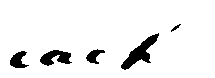

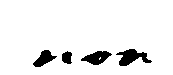

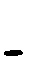

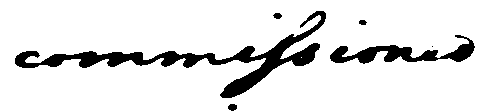

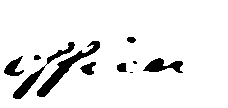

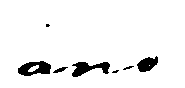

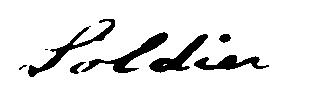

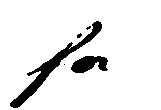

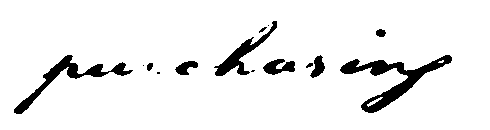

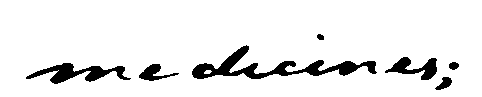

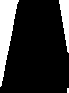

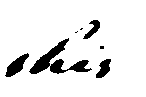

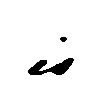

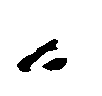

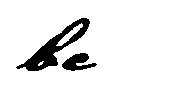

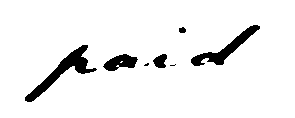

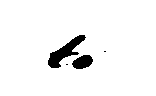

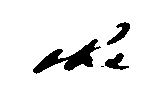

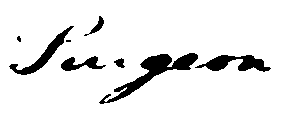

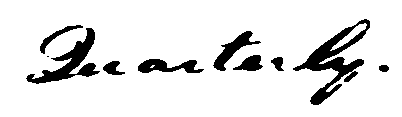

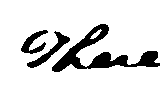

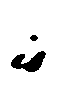

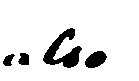

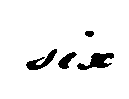

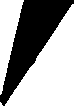

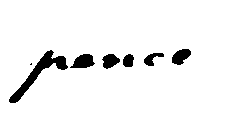

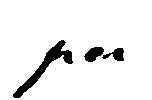

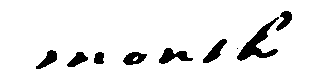

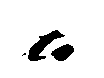

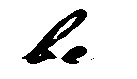

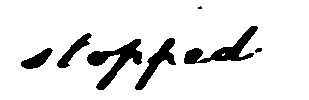

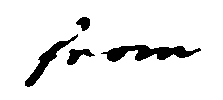

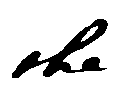

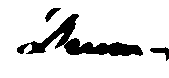

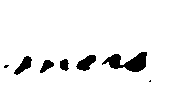

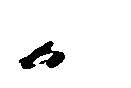

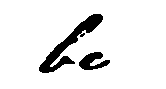

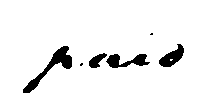

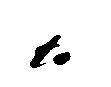

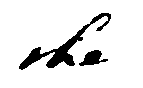

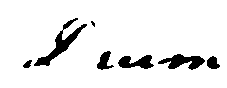

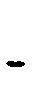

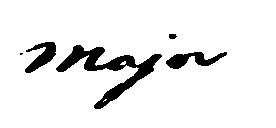

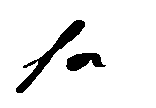

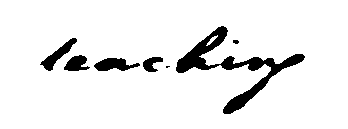

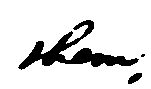

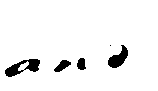

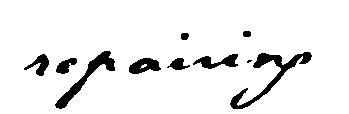

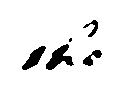

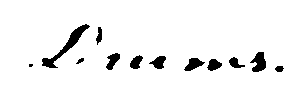

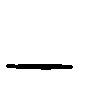

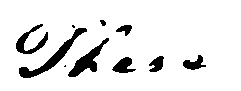

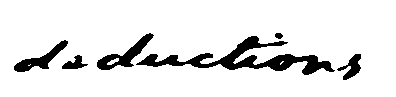

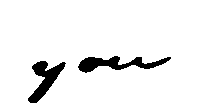

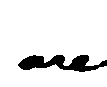

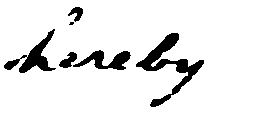

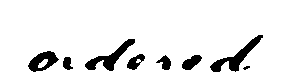

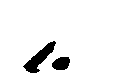

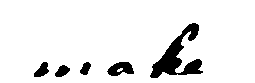

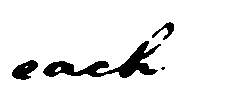

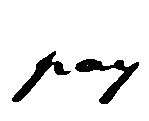

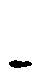

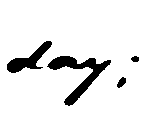

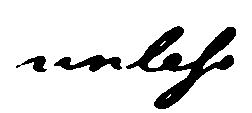

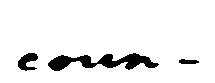

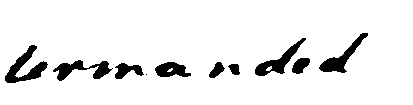

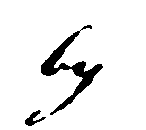

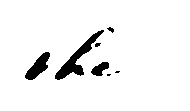

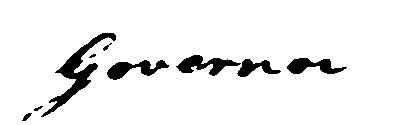

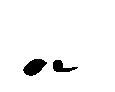

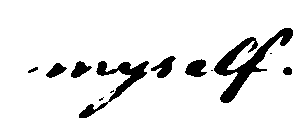

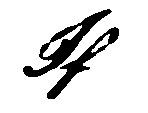

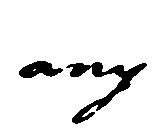

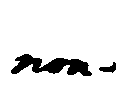

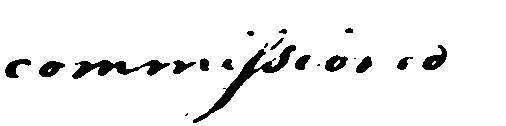

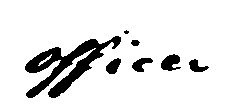

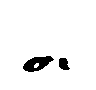

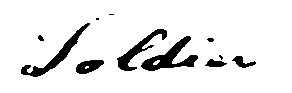

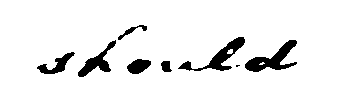

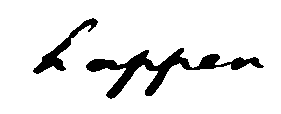

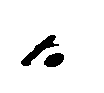

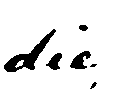

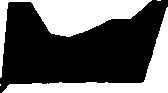

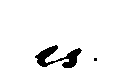

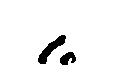

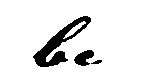

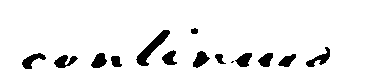

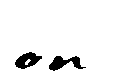

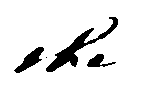

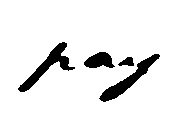

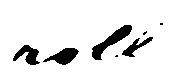

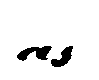

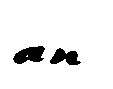

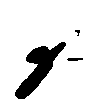

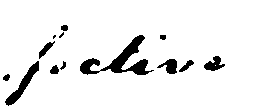

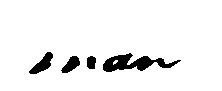

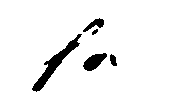

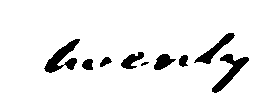

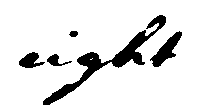

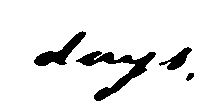

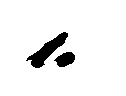

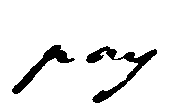

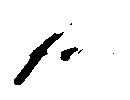

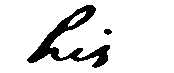

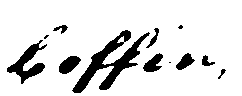

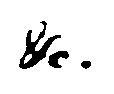

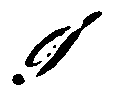

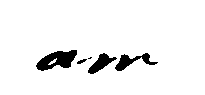

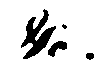

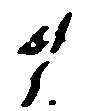

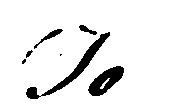

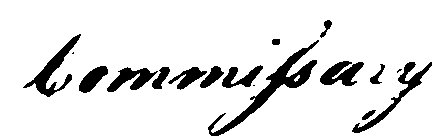

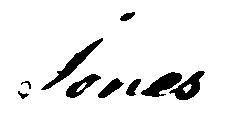

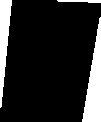

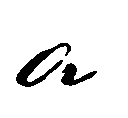

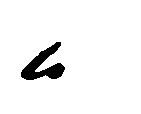

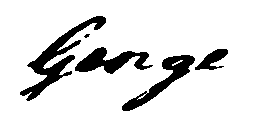

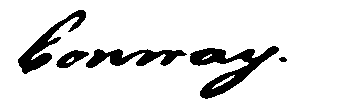

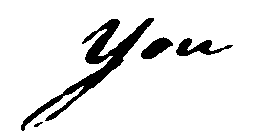

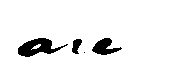

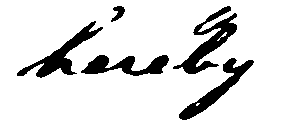

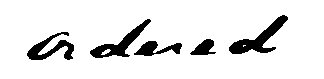

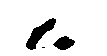

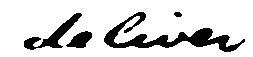

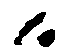

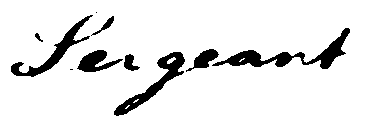

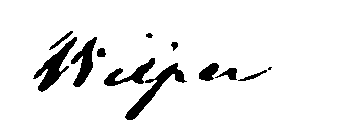

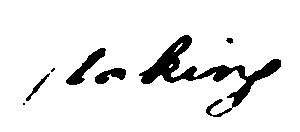

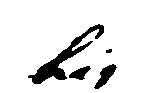

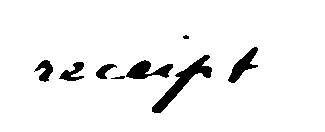

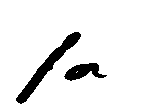

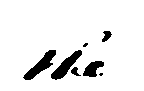

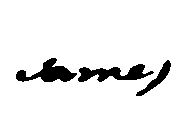

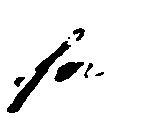

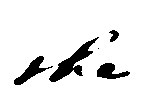

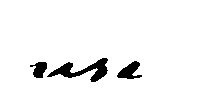

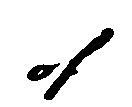

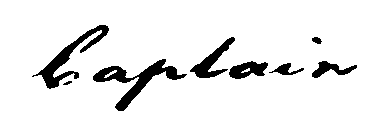

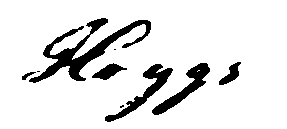

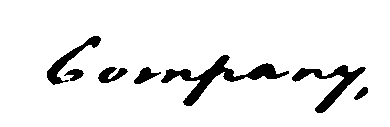

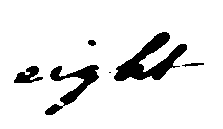

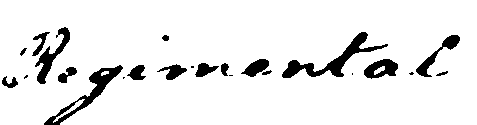

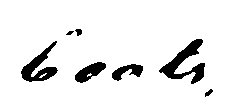

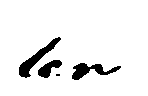

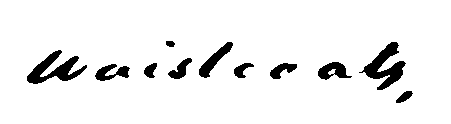

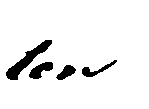

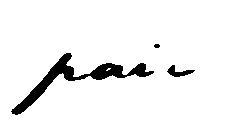

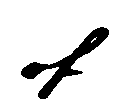

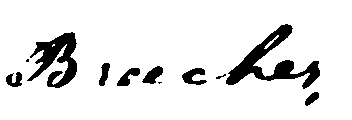

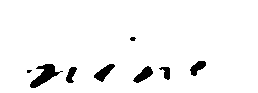

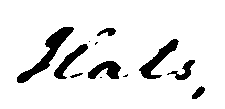

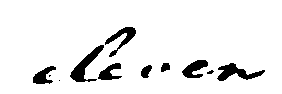

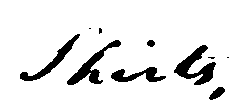

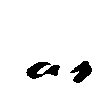

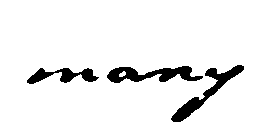

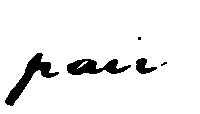

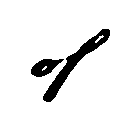

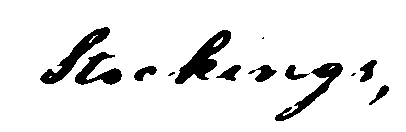

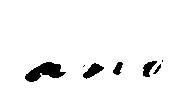

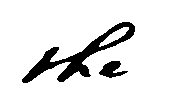

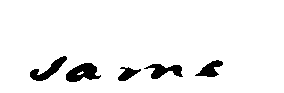

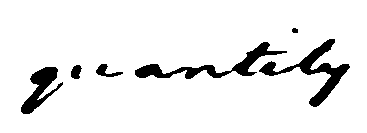

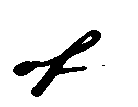

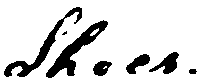

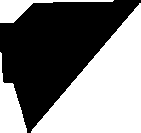

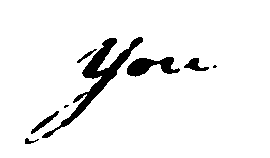

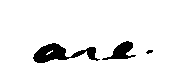

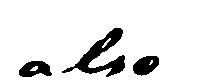

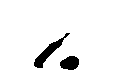

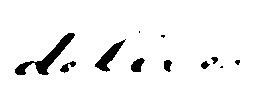

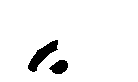

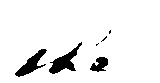

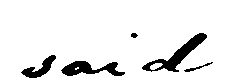

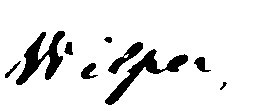

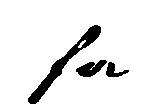

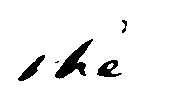

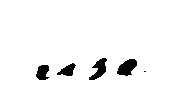

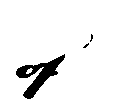

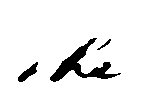

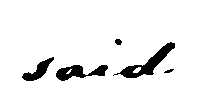

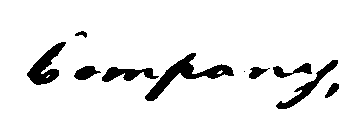

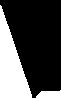

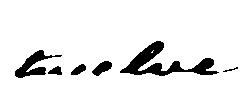

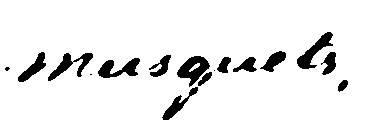

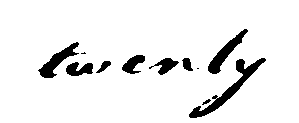

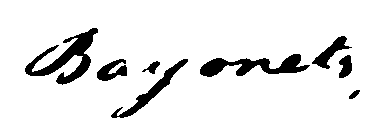

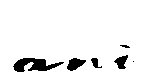

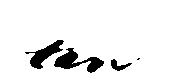

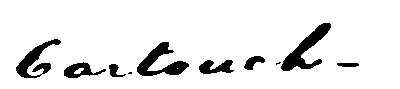

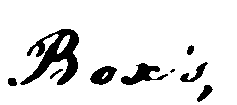

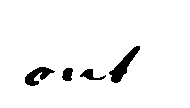

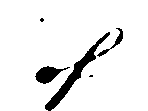

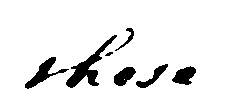

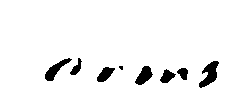

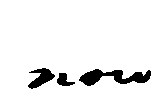

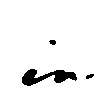

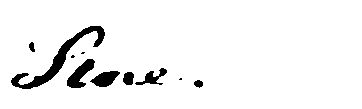

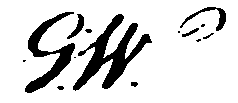

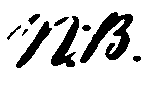

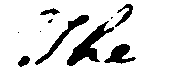

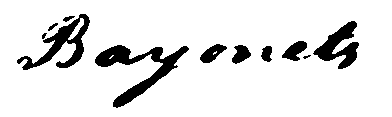

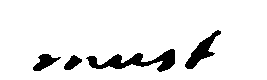

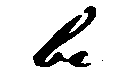

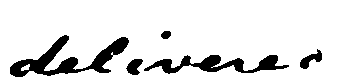

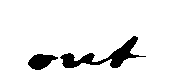

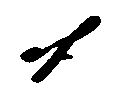

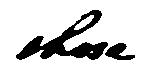

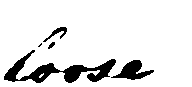

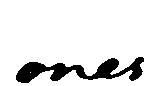

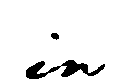

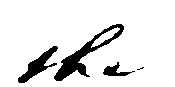

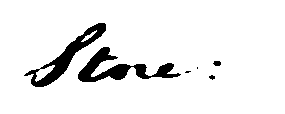

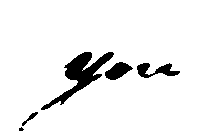

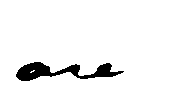

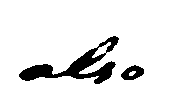

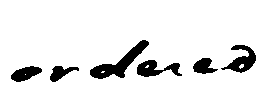

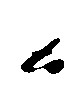

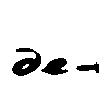

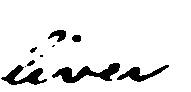

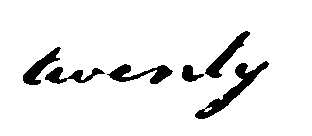

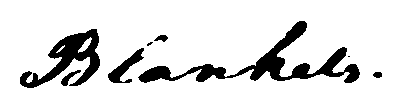

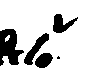

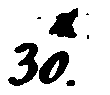

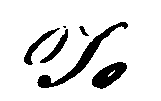

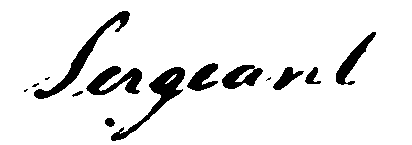

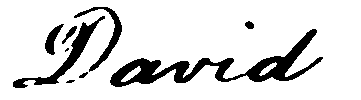

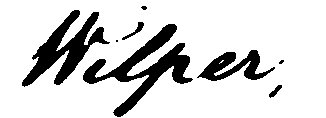

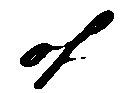

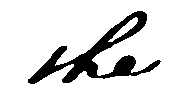

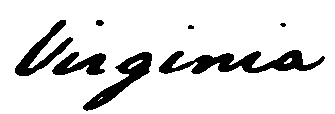

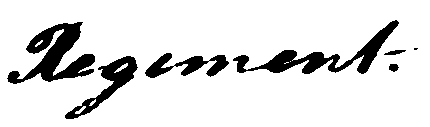

In [10]:
for img in get_binarized_words(train_id):
    display(img)